In [282]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.transforms as mtransforms
import matplotlib.dates as mdates
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

In [122]:
df_=pd.read_csv('tea_demand.csv')
df_.head(3)

,brand_id\tdate\treceipts_count
0,5152\t2016-07-01\t98
1,178\t2016-07-01\t234
2,29\t2016-07-01\t622


In [123]:
cols=df_.columns
cols=cols[0].split('\t')
cols

['brand_id', 'date', 'receipts_count']

In [124]:
df=pd.DataFrame(columns=['brand_id', 'date', 'receipts_count'])
df[['brand_id', 'date', 'receipts_count']]=df_.apply(lambda x: pd.Series(x.iloc[0].split('\t')),axis=1)
df.head(3)


,brand_id,date,receipts_count
0,5152,2016-07-01,98
1,178,2016-07-01,234
2,29,2016-07-01,622


In [125]:
df['timestamp']=pd.to_datetime(df['date'])
df['receipts_count']=df['receipts_count'].astype(int) 

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   brand_id        459 non-null    object        
 1   date            459 non-null    object        
 2   receipts_count  459 non-null    int32         
 3   timestamp       459 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int32(1), object(2)
memory usage: 12.7+ KB


In [127]:
df.head(3)

,brand_id,date,receipts_count,timestamp
0,5152,2016-07-01,98,2016-07-01
1,178,2016-07-01,234,2016-07-01
2,29,2016-07-01,622,2016-07-01


In [142]:
#расширить датасет новыми свойствами: день недели и день месяца
df['WeekDay'] = df['timestamp'].dt.dayofweek
df['MDay'] = df['timestamp'].dt.day
df[:6]

,brand_id,date,receipts_count,timestamp,DayOfTheWeek,DayOfMonth,WeekDay,MDay
0,5152,2016-07-01,98,2016-07-01,4,1,4,1
1,178,2016-07-01,234,2016-07-01,4,1,4,1
2,29,2016-07-01,622,2016-07-01,4,1,4,1
3,5152,2016-07-02,87,2016-07-02,5,2,5,2
4,178,2016-07-02,185,2016-07-02,5,2,5,2
5,29,2016-07-02,580,2016-07-02,5,2,5,2


In [169]:
map={29:0,178:1,5152:2}
y=df['brand_id'].astype(int).apply(lambda x:map[x])
y[:6]

0    2
1    1
2    0
3    2
4    1
5    0
Name: brand_id, dtype: int64

In [156]:
# добавить фичу сумма продаж по всем чаям в этот день
gr=df.groupby(['date'])['receipts_count'].sum()
df['sumlam']=df['date'].apply(lambda x:gr[x])
df[:6]

date
2016-07-01     954
2016-07-02     852
2016-07-03     982
2016-07-04     887
2016-07-05    1002
2016-07-06    1065
Name: receipts_count, dtype: int32

In [187]:
# выбрать часть столбцов для последующей кластеризации данных
X = df[['receipts_count', 'WeekDay', 'MDay','sumlam']].copy()
X[:6]

,receipts_count,WeekDay,MDay,sumlam
0,98,4,1,954
1,234,4,1,954
2,622,4,1,954
3,87,5,2,852
4,185,5,2,852
5,580,5,2,852


In [190]:
# выполнить нормализацию выбранного набора и уменьшение пространства признаков
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
pca2 = PCA(n_components=2)
X_new = pca2.fit_transform(X)

In [193]:
X_new[:10]

array([[-2.0064495 , -0.04226772],
       [-1.67708734, -0.0434231 ],
       [-0.73743645, -0.04671934],
       [-2.41512048,  0.46704098],
       [-2.17778598,  0.46620843],
       [-1.22118263,  0.46285273],
       [-1.93775432,  0.97544478],
       [-1.73190297,  0.97472267],
       [-0.528278  ,  0.97050043],
       [-1.65609157, -1.83284578]])

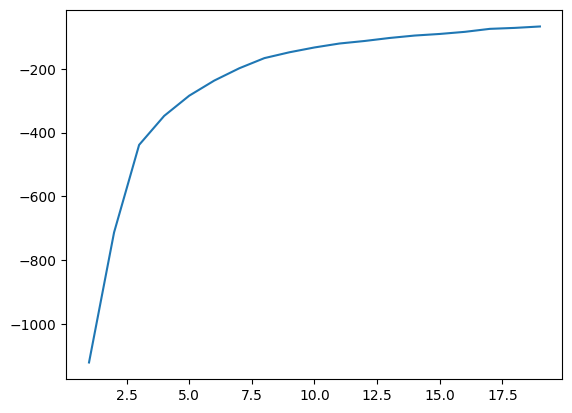

In [191]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=j).fit(X_new) for j in n_cluster]
scores = [km.score(X_new) for km in kmeans]
#оценить оптимальное число кластеров, совпадает ли оно с известным, равным 3?
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [195]:
df['cluster'] = kmeans[2].predict(X_new)
df['principal_feature1'] = X_new[:,0]
df['principal_feature2'] = X_new[:,1]
df['cluster'].value_counts()

2    191
0    172
1     96
Name: cluster, dtype: int64

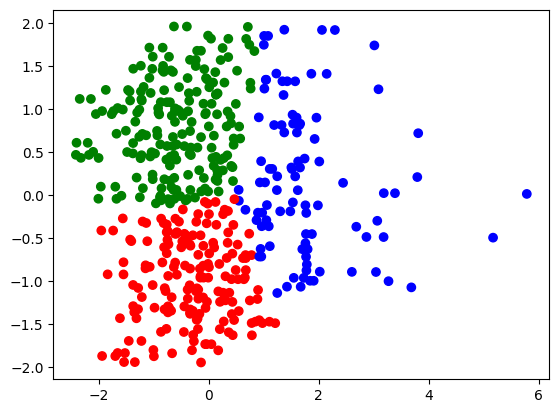

In [196]:
# как раскластеризовано множество инструментом kmeans?
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [ ]:
# вроде красиво, НО

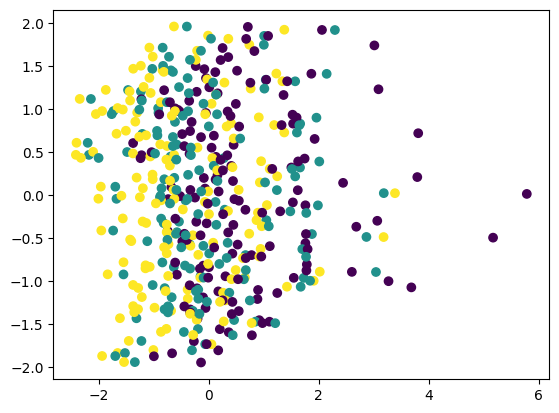

In [197]:
# если раскрасить в соответствии с марками чая:
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=y)
plt.show()
# то видно, что поделено неправильно, точки разных реальных кластеров перемешаны

In [ ]:
# вывод: имеющийся набор данных, расширенный некоторыми дополнительными фичами 
# не удалось выбранным методом поделить на группы, даже заранее зная, сколько отдельных кластеров.

In [199]:
# повторить опыт , расширив первоначальный набор фич.
X = df[['receipts_count', 'WeekDay', 'MDay','sumlam']].copy()
X[:6]

,receipts_count,WeekDay,MDay,sumlam
0,98,4,1,954
1,234,4,1,954
2,622,4,1,954
3,87,5,2,852
4,185,5,2,852
5,580,5,2,852


In [200]:
#добавить новые признаки (количество продаж данного чая на дату, считая от 1 до 9 дней назад)
for i in range(1,10):
    X[f'rcnt_{i:0>2}'] = X.receipts_count.shift(3*i)
X.fillna(0,inplace=True)
X[:6]
# в данном случае использовано предварительное знание о трех кластерах.
# последующее отображение в пространстве PCA точек не является кластеризацией, как таковой.
# (без добавления shift фичей пространство PCA еще менее четко показывает деление множества на кластеры.)

,receipts_count,WeekDay,MDay,sumlam,rcnt_01,rcnt_02,rcnt_03,rcnt_04,rcnt_05,rcnt_06,rcnt_07,rcnt_08,rcnt_09
0,98,4,1,954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,234,4,1,954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,622,4,1,954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,87,5,2,852,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,185,5,2,852,234.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,580,5,2,852,622.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [201]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
# The PCA model
pca2 = PCA(n_components=2) # estimate only 2 PCs
X_new = pca2.fit_transform(X) # project the original data into the PCA space

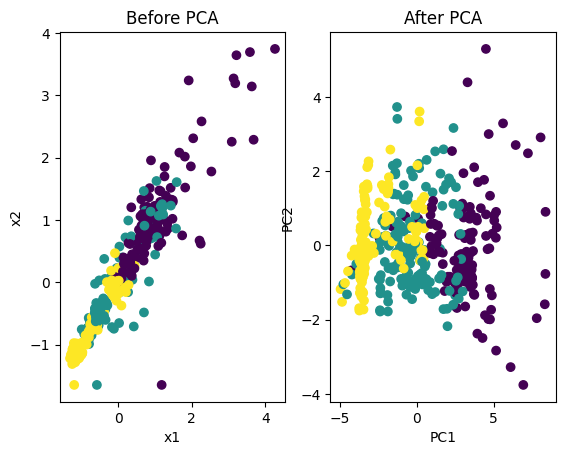

In [202]:
fig, axes = plt.subplots(1,2)
axes[0].scatter(X[:,0], X[:,4], c=y) #например, связь продаж сегодня и вчера
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].set_title('Before PCA')
axes[1].scatter(X_new[:,0], X_new[:,1], c=y) #уменьшенное до двух пространство признаков
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('After PCA')
plt.show()

In [ ]:
# еще более расширенный дополнительными фичами набор данных 

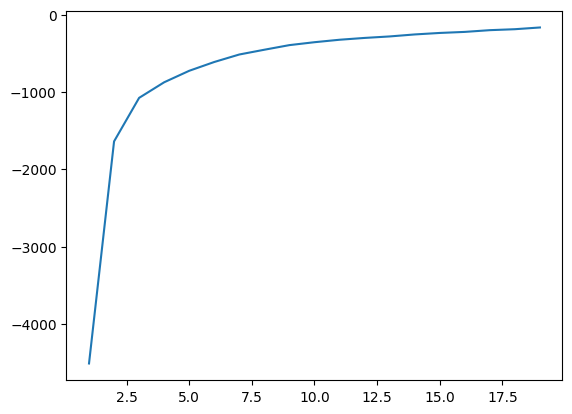

In [204]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=j).fit(X_new) for j in n_cluster]
scores = [km.score(X_new) for km in kmeans]
#оценить оптимальное число кластеров, совпадает ли оно с известным, равным 3?
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [205]:
df['cluster'] = kmeans[2].predict(X_new)
df['principal_feature1'] = X_new[:,0]
df['principal_feature2'] = X_new[:,1]
df['cluster'].value_counts()

2    159
1    151
0    149
Name: cluster, dtype: int64

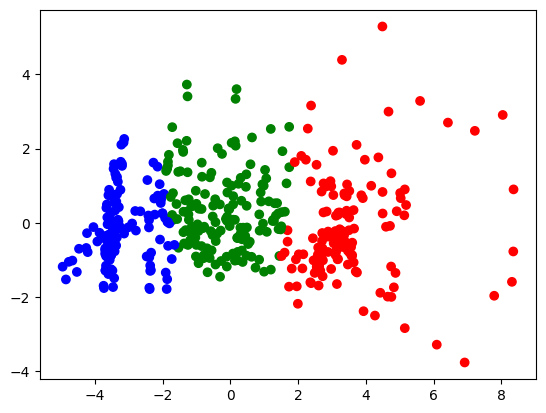

In [206]:
# как раскластеризовано множество инструментом kmeans?
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

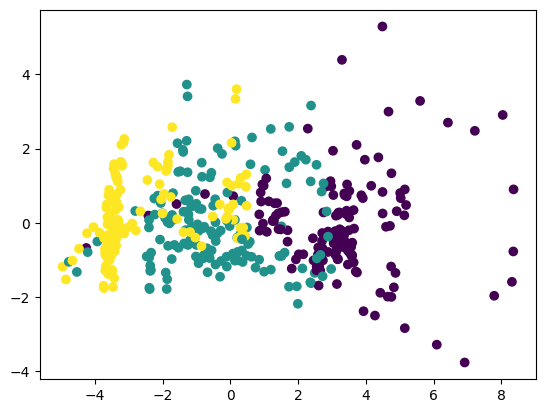

In [207]:
# если раскрасить в соответствии с марками чая:
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=y)
plt.show()
# то видно, что поделено "не очень", но лучше, чем в первом(без шифт фич) случае 

In [208]:
# вывод: при добавлении информации о прошлых значениях временного ряда, кластеризация более соответствует реальности
# хотя кластеры все-таки выявлены не четко

In [214]:
pca2.components_

array([[ 0.29288447, -0.00464939,  0.03514688,  0.05321255,  0.30748628,
         0.31857967,  0.32498563,  0.32824375,  0.32794483,  0.32456602,
         0.31857859,  0.31013899,  0.30026711],
       [ 0.21168311, -0.18324307,  0.52507034,  0.70918813,  0.17270528,
         0.10777202,  0.04270173, -0.01472576, -0.075545  , -0.12862049,
        -0.16084303, -0.16863195, -0.15141291]])

In [220]:
# цельнотянутая функция показывает, какие из фич в какую сторону влияют на разнесение точек множества 
# по принципиальным компонентам 1 и 2: (например, 2,3,4 растягивают множество в измерении PC2, остальные более влияют на PC1)
def biplot(score, coeff , y):
    '''
    Author: Serafeim Loukas, serafeim.loukas@epfl.ch
    Inputs:
       score: the projected data
       coeff: the eigenvectors (PCs)
       y: the class labels
   '''
    xs = score[:,0] # projection on PC1
    ys = score[:,1] # projection on PC2
    n = coeff.shape[0] # number of variables
    plt.figure(figsize=(10,8), dpi=100)
    classes = np.unique(y)
    colors = ['g','r','y']
    markers=['o','^','x']
    for s,l in enumerate(classes):
        plt.scatter(xs[y==l],ys[y==l], c = colors[s], marker=markers[s]) # color based on group
    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0, 0, coeff[i,0]*5, coeff[i,1]*5, color = 'k', alpha = 0.9,linestyle = '-',linewidth = 1.5, overhang=0.2)
        plt.text(coeff[i,0]* 5, coeff[i,1] * 5, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center',fontsize=10)

    plt.xlabel("PC{}".format(1), size=14)
    plt.ylabel("PC{}".format(2), size=14)
    limx= int(xs.max()) + 1
    limy= int(ys.max()) + 1
    plt.xlim([-limx,limx])
    plt.ylim([-limy,limy])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)

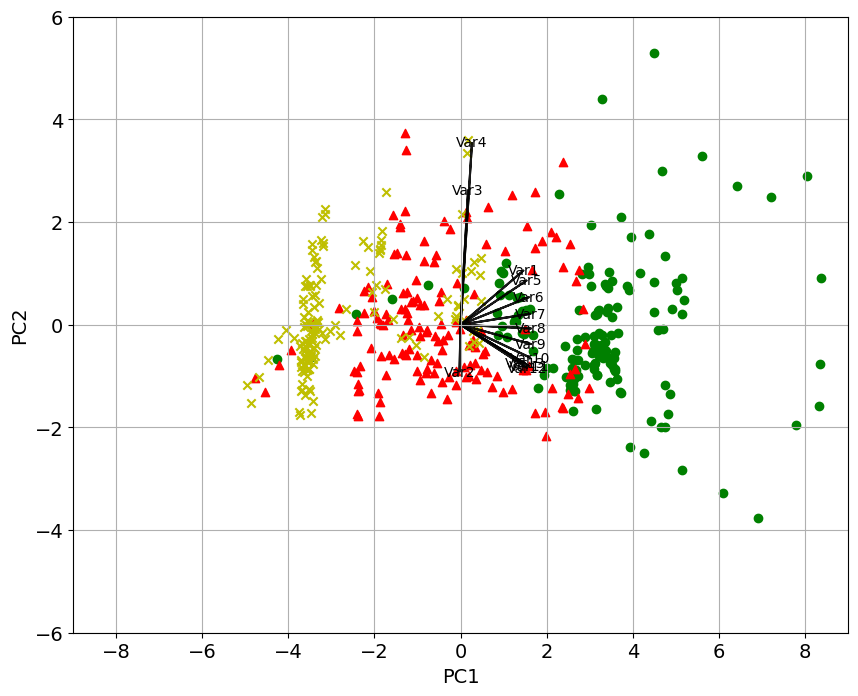

In [222]:
biplot(X_new[:,0:2], np.transpose(pca2.components_[0:2, :]), y)
plt.show()

In [140]:
# lipton = df.loc[df['brand_id'].astype(int) == 29, ['timestamp', 'receipts_count']]
# lipton[:4]

,timestamp,receipts_count
2,2016-07-01,622
5,2016-07-02,580
8,2016-07-03,687
11,2016-07-04,550


In [209]:
#разделить датасет по разным чаям,
# и приготовить персентили для оценки статистических выбросов
tea={'lipton':29,'ahmad':178,'may':5152}
def leftrightbound(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    return q1-1.5*iqr,q3+1.5*iqr
dftea=[]
aa=[]
for key,val in tea.items():
    print(key,val)
    # здесь формируются отдельные датасеты по разным чаям
    dftea.append(df.loc[df['brand_id'].astype(int) == val, ['timestamp', 'receipts_count']])
    le,ri=leftrightbound(dftea[-1].loc[:,'receipts_count'])   
    # здесь точки, за пределами 25 и 75 персентилей
    aa.append(dftea[-1].loc[(dftea[-1]['receipts_count'] < le) | (dftea[-1]['receipts_count'] > ri), ['timestamp', 'receipts_count']]) #anomaly


lipton 29
ahmad 178
may 5152


In [210]:
#приготовить к слиянию все чаи
ren=['lipton','ahmad','may']
for ind,dft in enumerate(dftea):
    # изменить имя столбца продаж под индивидуальный чай
    dft.rename(columns={'receipts_count':ren[ind]},inplace=True)
dftea[0].sample(3)

,timestamp,lipton
95,2016-08-01,688
101,2016-08-03,616
437,2016-11-23,425


In [227]:
# объединить в единый датасет
comb=dftea[0].merge(dftea[1],on='timestamp').merge(dftea[2],on='timestamp')
comb.sample(3)

,timestamp,lipton,ahmad,may
7,2016-07-08,592,370,87
123,2016-11-01,620,515,277
12,2016-07-13,647,287,128


из интернет-источника 1tv установлены даты прямого эфира тв шоу "что,где,когда"
изучение передач в записи не дало информации, была ли реклама чая, и какого именно.
так же не найдено никакой информации из других источников по поводу рекламы на этом шоу.
поэтому пока принято, что по условиям задачи реклама чая транслировалась на каждом тв шоу в заданный период.
![](1tv.png)

In [ ]:
tvshowdate=['2016-09-25','2016-10-02','2016-10-09','2016-10-16','2016-10-23','2016-11-20','2016-11-27']
#добавить столбец для вывода на сводном графике баров(на полную высоту для самых больших продаж), соответствующих дням показа
tvshow = pd.DataFrame({'date': tvshowdate, 'receipts_count': [df['receipts_count'].max() for i in range(len(tvshowdate))]})
tvshow['timestamp']=pd.to_datetime(tvshow['date'])
tvshow


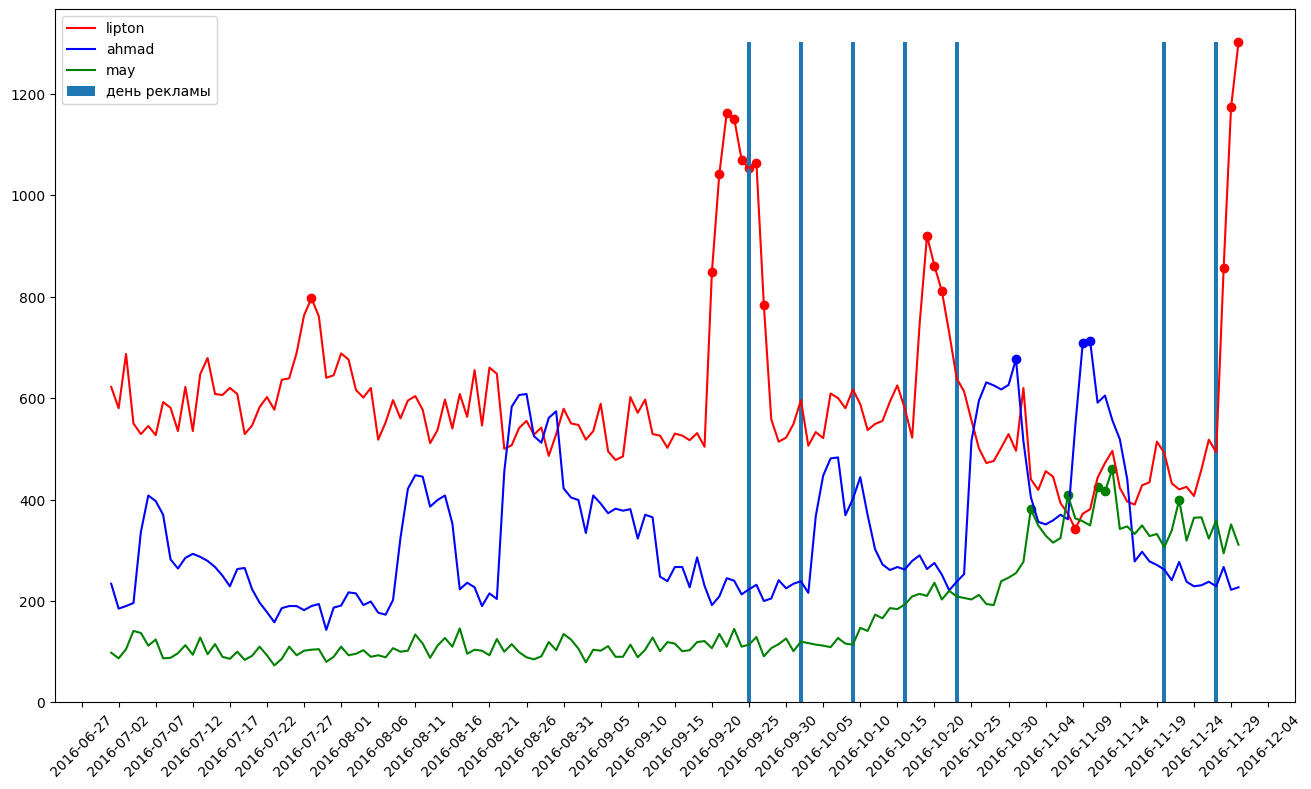

In [213]:
# вывести по трем чаям графики спроса с обозначением статистических выбросов
fig, ax = plt.subplots(figsize=(16,9))
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
for ind,dft in enumerate(dftea):
    #вывести все продажи по трем чаям
    ax.plot(dft['timestamp'], dft[ren[ind]], color=colors[ind],label =ren[ind])
    #вывести точки вне 25 и 75 персентилей
    ax.scatter(aa[ind]['timestamp'],aa[ind]['receipts_count'], color=colors[ind])
#вывести бары на днях, когда показано тв шоу что,где,когда
ax.bar(tvshow['timestamp'], tvshow['receipts_count'],width=0.5,label ='день рекламы')
locator = mdates.DayLocator(interval=5)
ax.xaxis.set_major_locator(locator)
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
# по характеру синей линии ахмад чая и вертикальным линиям дней рекламы вроде нельзя утверждать, что
# реклама(если она была в этот день) как-то однозначно влияет на продажи.....

In [288]:
dftea[1].sample(3)

,timestamp,ahmad
37,2016-07-13,287
352,2016-10-26,595
148,2016-08-19,227


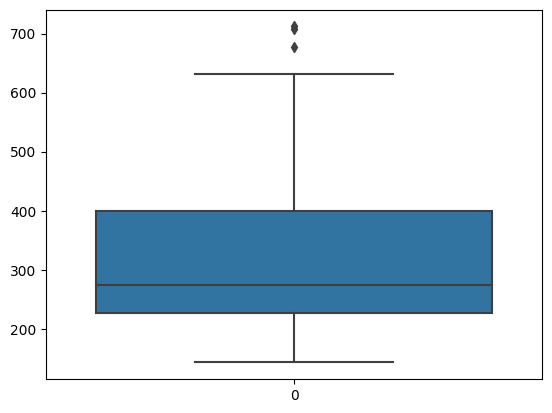

In [296]:
# Построим BoxPlot по продажам ахмад и посмотрим, выбросы, которые уже на предыдущем шаге отображены круглыми точками
sns.boxplot(dftea[1]['ahmad'].values)
plt.show()

In [228]:
#расширить данные новыми признаками:
# создать датасет с днями твшоу
tv=tvshow.drop(['date','receipts_count'],axis=1)
# определить новый признак - типа была реклама в эти дни
tv['isrekl']=1 #была ли в этот день реклама (на тв шоу что где когда)
# объединить с исходным датасетом
comb=comb.merge(tv,how='left',on='timestamp')
comb.head(4)

,timestamp,lipton,ahmad,may,isrekl
0,2016-07-01,622,234,98,NaN
1,2016-07-02,580,185,87,NaN
2,2016-07-03,687,190,105,NaN
3,2016-07-04,550,196,141,NaN


In [229]:
#датасет со столбцом 'isrekl' 1/0- была/не было передачи что,где когда 
# дополнить наны нулями - в остальные даты не было рекламы
comb.loc[comb['isrekl'].isnull(),['isrekl']]=0
comb.query('timestamp> "2016-09-20"') #просто посмотреть, что получилось

,timestamp,lipton,ahmad,may,isrekl
82,2016-09-21,1042,209,135,0.0
83,2016-09-22,1162,245,110,0.0
84,2016-09-23,1151,240,145,0.0
85,2016-09-24,1070,213,110,0.0
86,2016-09-25,1053,223,114,1.0
...,...,...,...,...,...
148,2016-11-26,518,238,323,0.0
149,2016-11-27,493,229,359,1.0
150,2016-11-28,856,267,294,0.0
151,2016-11-29,1173,222,351,0.0


In [231]:
#расширить датасет новыми свойствами: день недели и день месяца
comb['WeekDay'] = comb['timestamp'].dt.dayofweek
comb['MDay'] = comb['timestamp'].dt.day    
#добавить сумму продаж по всем чаям для оценки, если предпочтения покупателей смещаются в пределах разных чаев, но общее количество не сильно меняется
comb['sumlam'] = comb[['lipton','ahmad','may']].sum(axis=1)    
#добавить новые признаки (на текущую дату, считая от 1 до 9 дней назад было твшоу и,соответственно, реклама чая )
for i in range(1,10):
    comb[f'isrekl_{i:0>2}'] = comb.isrekl.shift(i)
# добавить продажи ахмада за предыдущие 9 дней
for i in range(1,10):
    comb[f'ahmad_{i:0>2}'] = comb.ahmad.shift(i)    
comb.query('timestamp> "2016-09-21"')

,timestamp,lipton,ahmad,may,isrekl,WeekDay,MDay,sumlam,isrekl_01,isrekl_02,...,isrekl_09,ahmad_01,ahmad_02,ahmad_03,ahmad_04,ahmad_05,ahmad_06,ahmad_07,ahmad_08,ahmad_09
83,2016-09-22,1162,245,110,0.0,3,22,1517,0.0,0.0,...,0.0,209.0,192.0,230.0,286.0,227.0,267.0,267.0,239.0,248.0
84,2016-09-23,1151,240,145,0.0,4,23,1536,0.0,0.0,...,0.0,245.0,209.0,192.0,230.0,286.0,227.0,267.0,267.0,239.0
85,2016-09-24,1070,213,110,0.0,5,24,1393,0.0,0.0,...,0.0,240.0,245.0,209.0,192.0,230.0,286.0,227.0,267.0,267.0
86,2016-09-25,1053,223,114,1.0,6,25,1390,0.0,0.0,...,0.0,213.0,240.0,245.0,209.0,192.0,230.0,286.0,227.0,267.0
87,2016-09-26,1063,232,129,0.0,0,26,1424,1.0,0.0,...,0.0,223.0,213.0,240.0,245.0,209.0,192.0,230.0,286.0,227.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2016-11-26,518,238,323,0.0,5,26,1079,0.0,0.0,...,0.0,231.0,229.0,238.0,277.0,241.0,262.0,271.0,278.0,297.0
149,2016-11-27,493,229,359,1.0,6,27,1081,0.0,0.0,...,0.0,238.0,231.0,229.0,238.0,277.0,241.0,262.0,271.0,278.0
150,2016-11-28,856,267,294,0.0,0,28,1417,1.0,0.0,...,0.0,229.0,238.0,231.0,229.0,238.0,277.0,241.0,262.0,271.0
151,2016-11-29,1173,222,351,0.0,1,29,1746,0.0,1.0,...,1.0,267.0,229.0,238.0,231.0,229.0,238.0,277.0,241.0,262.0


In [238]:
# отправить целевой столбец ахмад в начало (сделать индекс 0)
cols = comb.columns.tolist()
cols.insert(0, cols.pop(cols.index('ahmad')))
comb = comb[cols]
#убрать наны для лагов (первые строки датасета содержат наны из-за shift)
comb.loc[:10,:].fillna(0,inplace=True)
comb.head(12)


C:\Users\vsevolod.volkov\AppData\Local\Temp\ipykernel_11632\2847684297.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb.loc[:10,:].fillna(0,inplace=True)


,ahmad,timestamp,lipton,may,isrekl,WeekDay,MDay,sumlam,isrekl_01,isrekl_02,...,isrekl_09,ahmad_01,ahmad_02,ahmad_03,ahmad_04,ahmad_05,ahmad_06,ahmad_07,ahmad_08,ahmad_09
0,234,2016-07-01,622,98,0.0,4,1,954,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,185,2016-07-02,580,87,0.0,5,2,852,0.0,0.0,...,0.0,234.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,190,2016-07-03,687,105,0.0,6,3,982,0.0,0.0,...,0.0,185.0,234.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,196,2016-07-04,550,141,0.0,0,4,887,0.0,0.0,...,0.0,190.0,185.0,234.0,0.0,0.0,0.0,0.0,0.0,0.0
4,336,2016-07-05,529,137,0.0,1,5,1002,0.0,0.0,...,0.0,196.0,190.0,185.0,234.0,0.0,0.0,0.0,0.0,0.0
5,408,2016-07-06,545,112,0.0,2,6,1065,0.0,0.0,...,0.0,336.0,196.0,190.0,185.0,234.0,0.0,0.0,0.0,0.0
6,397,2016-07-07,527,124,0.0,3,7,1048,0.0,0.0,...,0.0,408.0,336.0,196.0,190.0,185.0,234.0,0.0,0.0,0.0
7,370,2016-07-08,592,87,0.0,4,8,1049,0.0,0.0,...,0.0,397.0,408.0,336.0,196.0,190.0,185.0,234.0,0.0,0.0
8,282,2016-07-09,581,88,0.0,5,9,951,0.0,0.0,...,0.0,370.0,397.0,408.0,336.0,196.0,190.0,185.0,234.0,0.0
9,264,2016-07-10,535,97,0.0,6,10,896,0.0,0.0,...,0.0,282.0,370.0,397.0,408.0,336.0,196.0,190.0,185.0,234.0


In [239]:
# 2016-10-20
split_date = '2016-10-20'
ahmad_train = comb.query('timestamp<="2016-10-20"').copy()
ahmad_test = comb.query('timestamp>"2016-10-20"').copy()


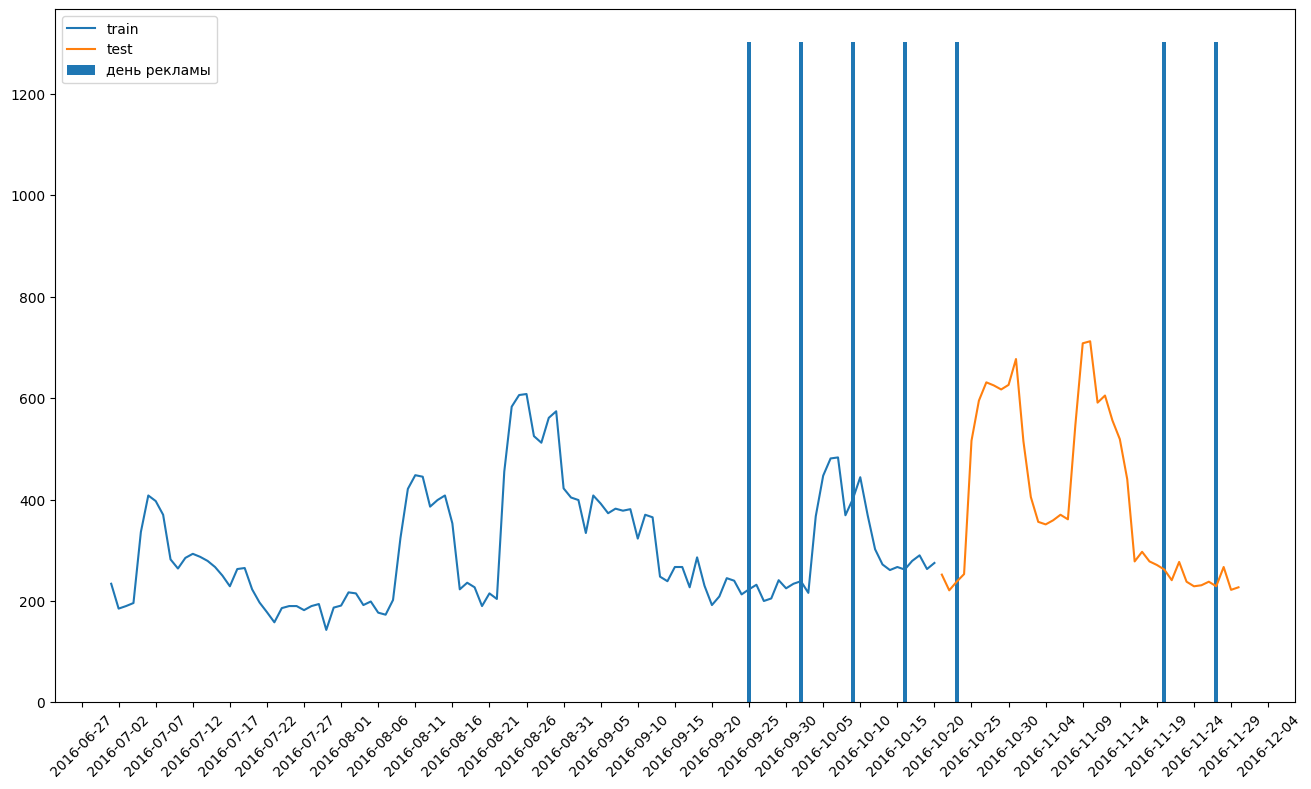

In [240]:
# вывести разным цветом трейн и тест выборку по продажам ахмад:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(ahmad_train['timestamp'], ahmad_train['ahmad'], label ='train')
ax.plot(ahmad_test['timestamp'], ahmad_test['ahmad'], label ='test')
#вывести бары на днях, когда показано тв шоу что,где,когда
ax.bar(tvshow['timestamp'], tvshow['receipts_count'],width=0.5,label ='день рекламы')
locator = mdates.DayLocator(interval=5)
ax.xaxis.set_major_locator(locator)
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [242]:
# %pip install xgboost


     ---------------------------------------- 70.9/70.9 MB 4.6 MB/s eta 0:00:00


In [252]:
# создать модель хгбуст
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

# в первом столбце содерижтся целевая переменная - продажи ахмад
# в остальных столбцах(кроме timestamp, который надо выкинуть,т.к. его тип не подходит хгбуст
#  и этот признак не информативен, а фактически служит индексом) - 
# разнообразные признаки, по которым делать прогноз
X_train, y_train=ahmad_train.iloc[:,2:],ahmad_train.iloc[:,0]
X_test, y_test=ahmad_test.iloc[:,2:],ahmad_test.iloc[:,0]


In [255]:

reg = xgb.XGBRegressor(n_estimators=2000,early_stopping_rounds=150)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=True) # Измените verbose на True, если хотите увидеть процесс обучения

[0]	validation_0-rmse:229.89852	validation_1-rmse:335.45614
[1]	validation_0-rmse:166.95603	validation_1-rmse:254.14691
[2]	validation_0-rmse:122.46469	validation_1-rmse:203.12955
[3]	validation_0-rmse:90.25191	validation_1-rmse:166.42435
[4]	validation_0-rmse:67.43957	validation_1-rmse:138.34593
[5]	validation_0-rmse:50.64062	validation_1-rmse:117.90564
[6]	validation_0-rmse:38.34044	validation_1-rmse:103.36875
[7]	validation_0-rmse:29.59981	validation_1-rmse:93.24942
[8]	validation_0-rmse:23.24879	validation_1-rmse:87.30213
[9]	validation_0-rmse:18.44291	validation_1-rmse:83.35801
[10]	validation_0-rmse:14.91880	validation_1-rmse:80.82550
[11]	validation_0-rmse:12.26447	validation_1-rmse:80.05035
[12]	validation_0-rmse:10.09084	validation_1-rmse:79.68564
[13]	validation_0-rmse:8.41248	validation_1-rmse:78.74752
[14]	validation_0-rmse:7.08173	validation_1-rmse:78.69106
[15]	validation_0-rmse:5.95198	validation_1-rmse:78.69082
[16]	validation_0-rmse:5.07425	validation_1-rmse:78.72609
[

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=150,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

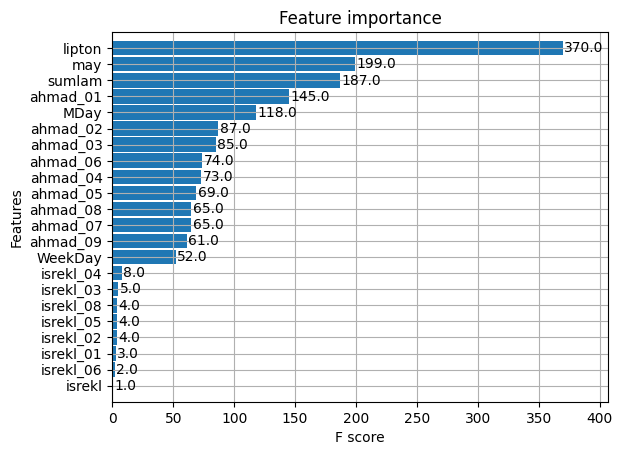

In [258]:
_ = plot_importance(reg, height=0.9)
plt.show()
# видно, что продажи ахмад сильно коррелируют с продажами липтон....
# с другой стороны из задания неясно, все чаи рекламировались, или только ахмад....
# так же видно, что влияние рекламы на прогноз здесь идет на последнем месте....

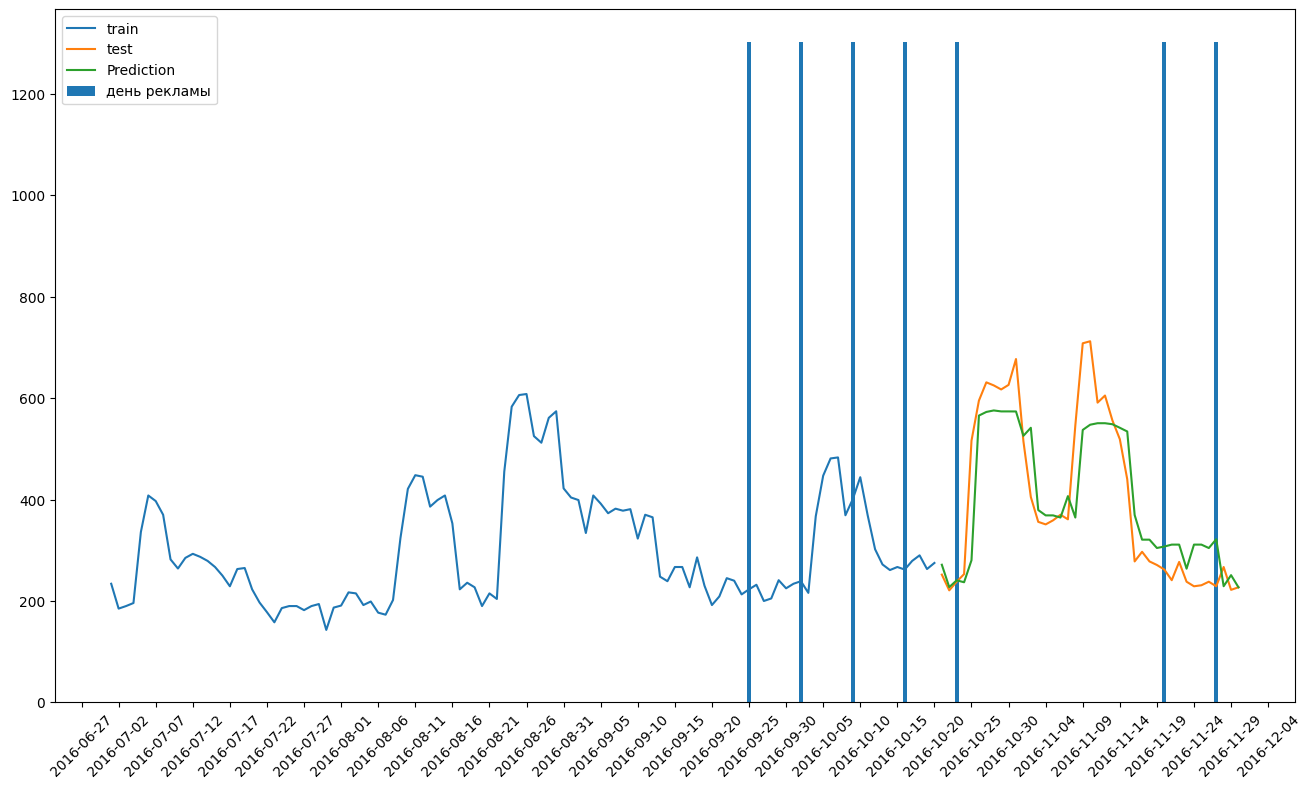

In [259]:
# построить тест и прогноз:  
ahmad_test['Prediction'] = reg.predict(X_test)
# вывести разным цветом трейн и тест выборку по продажам ахмад:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(ahmad_train['timestamp'], ahmad_train['ahmad'], label ='train')
ax.plot(ahmad_test['timestamp'], ahmad_test['ahmad'], label ='test')
ax.plot(ahmad_test['timestamp'], ahmad_test['Prediction'], label ='Prediction')
#вывести бары на днях, когда показано тв шоу что,где,когда
ax.bar(tvshow['timestamp'], tvshow['receipts_count'],width=0.5,label ='день рекламы')
locator = mdates.DayLocator(interval=5)
ax.xaxis.set_major_locator(locator)
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [261]:
ahmad_train.drop(['sumlam'],axis=1)

,ahmad,timestamp,lipton,may,isrekl,WeekDay,MDay,isrekl_01,isrekl_02,isrekl_03,...,isrekl_09,ahmad_01,ahmad_02,ahmad_03,ahmad_04,ahmad_05,ahmad_06,ahmad_07,ahmad_08,ahmad_09
0,234,2016-07-01,622,98,0.0,4,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,185,2016-07-02,580,87,0.0,5,2,0.0,0.0,0.0,...,0.0,234.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,190,2016-07-03,687,105,0.0,6,3,0.0,0.0,0.0,...,0.0,185.0,234.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,196,2016-07-04,550,141,0.0,0,4,0.0,0.0,0.0,...,0.0,190.0,185.0,234.0,0.0,0.0,0.0,0.0,0.0,0.0
4,336,2016-07-05,529,137,0.0,1,5,0.0,0.0,0.0,...,0.0,196.0,190.0,185.0,234.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,262,2016-10-16,580,193,1.0,6,16,0.0,0.0,0.0,...,0.0,267.0,261.0,272.0,302.0,369.0,444.0,401.0,369.0,483.0
108,279,2016-10-17,522,209,0.0,0,17,1.0,0.0,0.0,...,0.0,262.0,267.0,261.0,272.0,302.0,369.0,444.0,401.0,369.0
109,290,2016-10-18,745,214,0.0,1,18,0.0,1.0,0.0,...,1.0,279.0,262.0,267.0,261.0,272.0,302.0,369.0,444.0,401.0
110,263,2016-10-19,920,210,0.0,2,19,0.0,0.0,1.0,...,0.0,290.0,279.0,262.0,267.0,261.0,272.0,302.0,369.0,444.0


In [264]:
# что, если убрать данные о других чаях и оставить только ахмад???
X_train, y_train=ahmad_train.drop(['sumlam'],axis=1).iloc[:,4:],ahmad_train.drop(['sumlam'],axis=1).iloc[:,0]
X_test, y_test=ahmad_test.drop(['sumlam','Prediction'],axis=1).iloc[:,4:],ahmad_test.drop(['sumlam','Prediction'],axis=1).iloc[:,0]

In [265]:
reg = xgb.XGBRegressor(n_estimators=2000,early_stopping_rounds=150)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False) # Измените verbose на True, если хотите увидеть процесс обучения

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=150,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

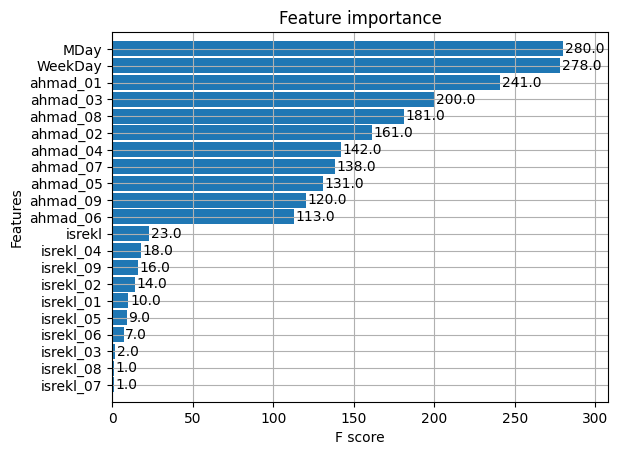

In [266]:
_ = plot_importance(reg, height=0.9)
plt.show()

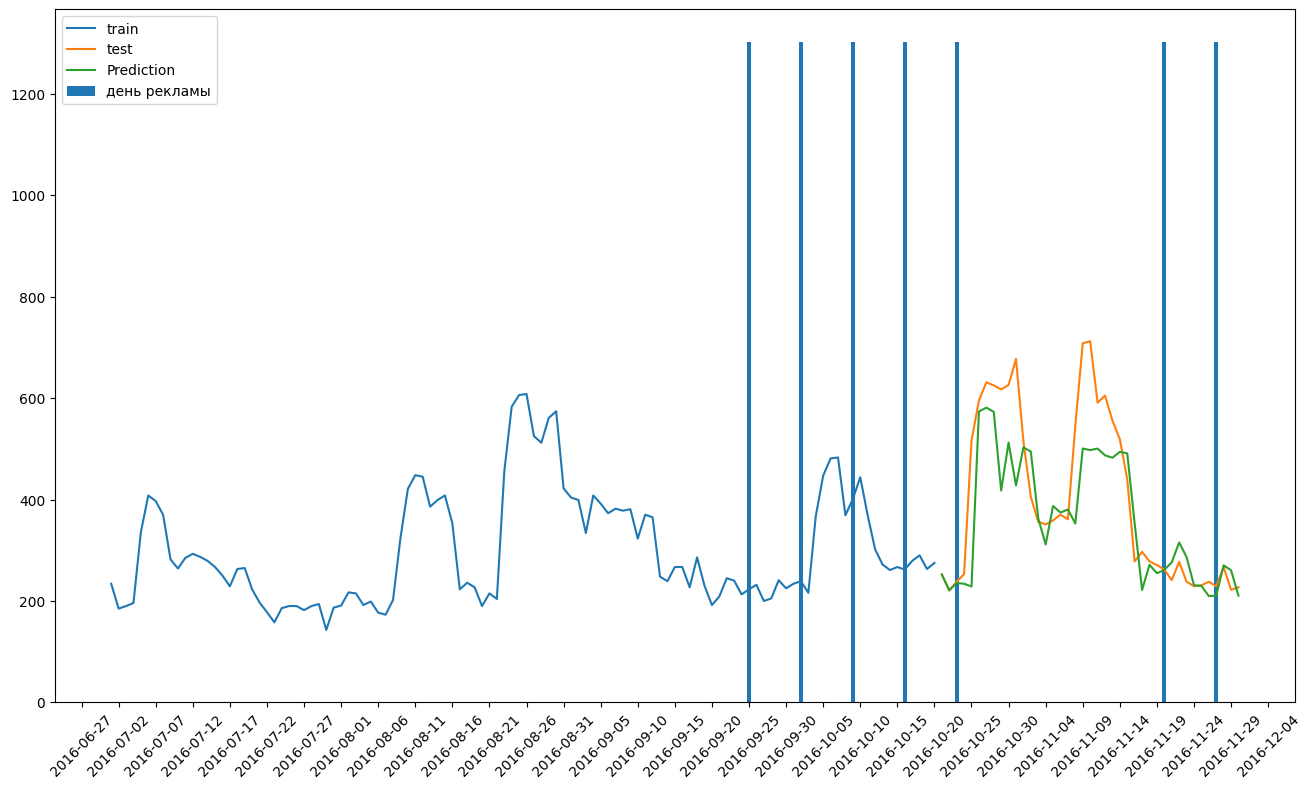

In [267]:
# построить тест и прогноз:  
ahmad_test['Prediction'] = reg.predict(X_test)
# вывести разным цветом трейн и тест выборку по продажам ахмад:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(ahmad_train['timestamp'], ahmad_train['ahmad'], label ='train')
ax.plot(ahmad_test['timestamp'], ahmad_test['ahmad'], label ='test')
ax.plot(ahmad_test['timestamp'], ahmad_test['Prediction'], label ='Prediction')
#вывести бары на днях, когда показано тв шоу что,где,когда
ax.bar(tvshow['timestamp'], tvshow['receipts_count'],width=0.5,label ='день рекламы')
locator = mdates.DayLocator(interval=5)
ax.xaxis.set_major_locator(locator)
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [278]:
# попробуем убрать информацию о рекламе:
cols=['isrekl']
cols.extend([f'isrekl_{i:0>2}' for i in range(1,10)])
cols

['isrekl',
 'isrekl_01',
 'isrekl_02',
 'isrekl_03',
 'isrekl_04',
 'isrekl_05',
 'isrekl_06',
 'isrekl_07',
 'isrekl_08',
 'isrekl_09']

In [280]:
# и снова построим прогноз
reg = xgb.XGBRegressor(n_estimators=2000,early_stopping_rounds=150)

X_train=X_train.drop(cols, axis=1)
X_test=X_test.drop(cols, axis=1)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False) # Измените verbose на True, если хотите увидеть процесс обучения

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=150,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

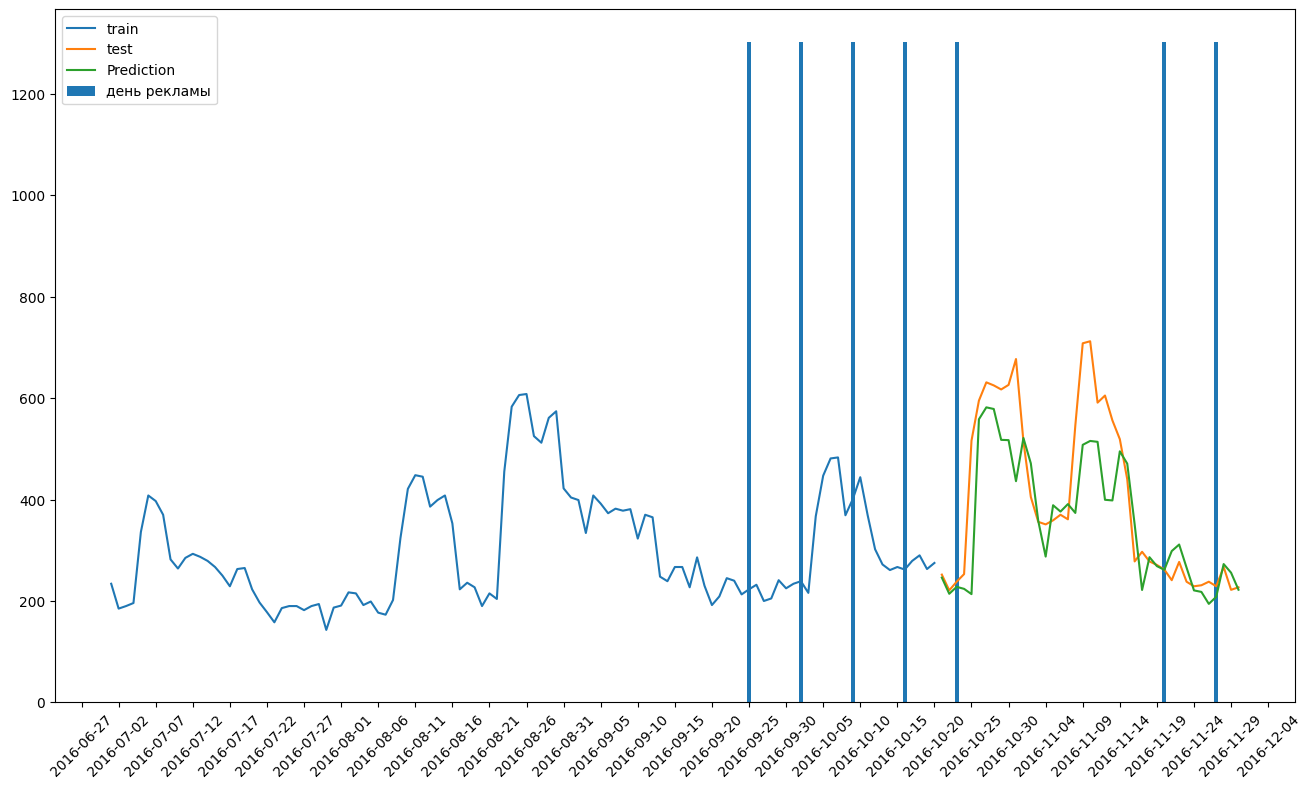

In [281]:
# построить тест и прогноз:  
ahmad_test['Prediction'] = reg.predict(X_test)
# вывести разным цветом трейн и тест выборку по продажам ахмад:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(ahmad_train['timestamp'], ahmad_train['ahmad'], label ='train')
ax.plot(ahmad_test['timestamp'], ahmad_test['ahmad'], label ='test')
ax.plot(ahmad_test['timestamp'], ahmad_test['Prediction'], label ='Prediction')
#вывести бары на днях, когда показано тв шоу что,где,когда
ax.bar(tvshow['timestamp'], tvshow['receipts_count'],width=0.5,label ='день рекламы')
locator = mdates.DayLocator(interval=5)
ax.xaxis.set_major_locator(locator)
plt.xticks(rotation=45)
plt.legend()
plt.show()

ничего в общем особо не изменилось, когда отбросили информацию о рекламе. 



# вывод:очевидно, реклама не влияет заметно на продажи.....